# Differential variability comparison plots

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

In [102]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [103]:
# import sys
# sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
# import memento
# import memento.simulate as simulate

In [104]:
import matplotlib
matplotlib.rcParams['legend.handlelength'] = 0

In [105]:
data_path = '/data_volume/memento/simulation/dv/'

### Compare DV methods

In [147]:
dv_adata = sc.read(data_path + 'anndata.h5ad')
result = dv_adata.var.copy()
result['de'] = dv_adata.var['is_de'].values
result['dv'] = dv_adata.var['is_dv'].values
result['dv_effect_size'] = dv_adata.var['dv_effect_size'].values
memento_dv = pd.read_csv(data_path + 'memento.csv', index_col=0)
basics_dv = pd.read_csv(data_path +'dv_basics.csv')
basics_dv.index = memento_dv.iloc[basics_dv['GeneName']].index.tolist()

result = memento_dv.join(result, how='left').join(basics_dv, how='left')


result['basics_es'] = basics_dv['ResDispDistance'] * (basics_dv['ResultDiffResDisp']=='stim+') - basics_dv['ResDispDistance'] * (basics_dv['ResultDiffResDisp']=='stim+')
result['basics'] = 1- basics_dv['ProbDiffResDisp']
result['basics'] =  result['basics'].fillna(1.0)
result['memento'] = result['pval']

In [150]:
n=10
thresholds = {
    'memento':np.linspace(0, 0.1, n),
    'basics':np.linspace(0, 0.1, n)}

tpr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in ['memento', 'basics']:
    tpr = []
    fpr = []
    fdr = []

    for thresh in thresholds[method]:
    
        tpr.append((result.query('dv')[method] < thresh).mean())
        fdr.append(1-result.query('{} < {}'.format(method, thresh))['dv'].mean())
        fpr.append(1-(result.query('dv')[method] < thresh).mean())
    tpr_dict[method] = tpr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

Text(0.5, 0, 'P-value cutoff (memento)\nPr(null) cutoff (BASiCS)')

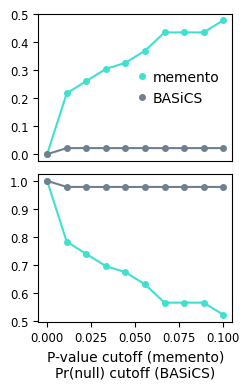

In [151]:
plt.figure(figsize=(2.5, 4))
plt.subplots_adjust(hspace=0.09)
plt.subplot(2, 1, 1)
for method in ['memento', 'basics']:
    plt.plot(thresholds[method], tpr_dict[method], '-o', label=method, ms=4)
plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
plt.xticks([])

plt.subplot(2, 1, 2)
for method in ['memento', 'basics']:
    plt.plot(thresholds[method], fpr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.ylabel('FPR')
plt.xlabel('P-value cutoff (memento)\nPr(null) cutoff (BASiCS)')

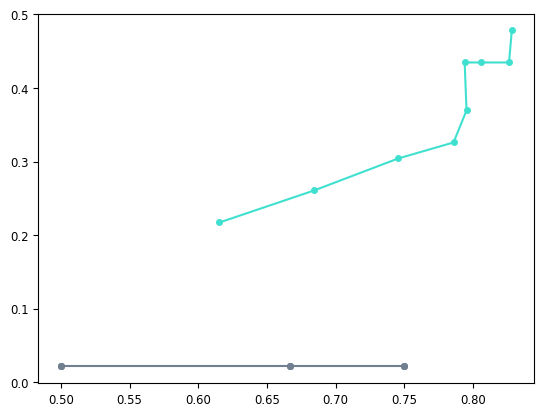

In [152]:
for method in ['memento', 'basics']:
    plt.plot(fdr_dict[method], tpr_dict[method], '-o', label=method, ms=4)

### Memento debugging

In [18]:
%load_ext autoreload

In [19]:
%autoreload 2

In [20]:
q=0.1
data_path = '/data_volume/memento/simulation/'

In [24]:
import sys
sys.path.append('/home/ssm-user/Github/memento')
import memento.model.rna as rna
import memento.estimator.hypergeometric as hg
import memento.util as util

import logging
logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.WARN, 
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [25]:
adata = sc.read(data_path + 'dv/anndata.h5ad')

adata.obs['q'] = q
adata.X = adata.X.astype(float)

rna.MementoRNA.setup_anndata(
        adata=adata,
        q_column='q',
        label_columns=['group', 'condition'],
        num_bins=30,
        trim_percent=0.03,
        shrinkage=0.0)

means = adata.X.mean(axis=0).A1
adata = adata[:, means > np.quantile(means, 0.95)]
model = rna.MementoRNA(adata=adata)

model.compute_estimate(
    estimand='var',
    get_se=False,
    n_jobs=30,
)
model.compute_estimate(
    estimand='mean',
    get_se=False,
    n_jobs=30,
)